In [273]:
from river import anomaly
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from river import feature_extraction as fx
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
import numpy as np




filename = 'dataset_adapted_pca.csv' # Mix 50% normal and 50% anomaly

In [274]:
model = compose.Pipeline(
    preprocessing.MinMaxScaler(),
    anomaly.HalfSpaceTrees(
        n_trees=25,
        height=10,
        window_size=250,
        seed=42
    )
)

In [275]:
# List of columns to keep
dataset = pd.read_csv(filename, index_col=False)


# Divide dataset into train and test
# Obtain 10000 samples for training that contains benign samples remove from the dataset
# Select first 10000 rows where 'Label' is 0
dataset_train = dataset.loc[dataset['Label'] == 0].iloc[:10000]

# Drop these rows from the original dataset
dataset_test = dataset.drop(dataset_train.index)

print("Number of elements in the training dataset: ", len(dataset_train))
print("Number of elements in the test dataset: ", len(dataset_test))
print("\tBenign samples: ", len(dataset_test.loc[dataset['Label'] == 0]))
print("\tAnomaly samples: ", len(dataset_test.loc[dataset['Label'] == 1]))

# Shuffle dataset_test
dataset_test = dataset_test.sample(frac=1).reset_index(drop=True)

# Separate the label
dataset_train_no_labels = dataset_train.drop(columns=['Label'])
dataset_test_no_labels = dataset_test.drop(columns=['Label'])

Number of elements in the training dataset:  10000
Number of elements in the test dataset:  10000
	Benign samples:  5000
	Anomaly samples:  5000


In [276]:
# Traning phase
scores_training = []

# Create a list of scores
for i, row in dataset_train_no_labels.iterrows():
    model.learn_one(row.to_dict())
    scores_training.append(model.score_one(row.to_dict()))  
    
print("Traning phase completed")


Traning phase completed


In [277]:
# Caracteristicas de los scores de la fase de entrenamiento

print("Media de los scores de la fase de entrenamiento: ", np.mean(scores_training))
print("Desviación estándar de los scores de la fase de entrenamiento: ", np.std(scores_training))
print("Máximo de los scores de la fase de entrenamiento: ", np.max(scores_training))
print("Mínimo de los scores de la fase de entrenamiento: ", np.min(scores_training))

Media de los scores de la fase de entrenamiento:  0.9501080493209574
Desviación estándar de los scores de la fase de entrenamiento:  0.1529758812960971
Máximo de los scores de la fase de entrenamiento:  0.9981192379091354
Mínimo de los scores de la fase de entrenamiento:  0.0


In [278]:
print(scores_training)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9853331509526135, 0.9871087054225696, 0.9873707083536883, 0.9911878847093307, 0.9848988764044944, 0.9920129750854909, 0.9506652857840743, 0.9842776355642403, 0.9899935515388373, 0.990558202247191, 0.9904687835857352, 0.9925488617489008, 0.97591198827

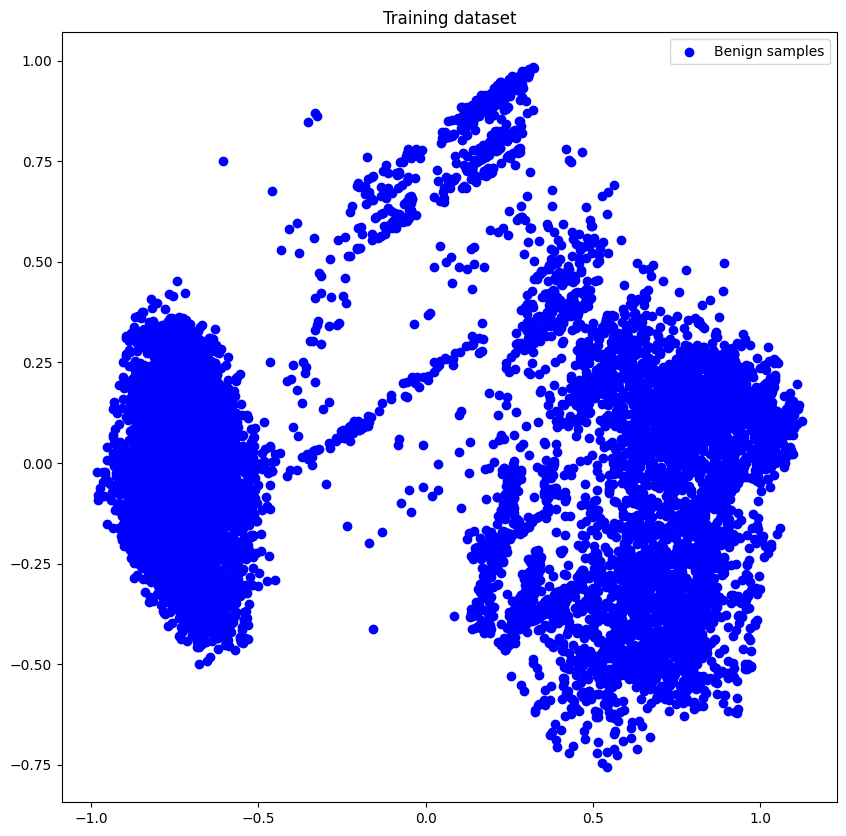

In [279]:
# Plot training dataset
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.figure(figsize=(10, 10))
plt.scatter(dataset_train_no_labels['PCA1'], dataset_train_no_labels['PCA2'], c='blue', label='Benign samples')
plt.title('Training dataset')

plt.legend(handler_map={plt.Line2D: HandlerPathCollection(update_func=update_legend_marker_size)})

plt.show()


In [280]:
# Testing phase

# Create a list of scores
scores = []
anomalias = []

correctos = 0
incorrectos = 0

correctos_quantile = 0
incorrectos_quantile = 0

valor_umbral = 0.96

for idx in dataset_test_no_labels.index:
    row = dataset_test_no_labels.loc[idx]
    print("Row: ", idx)
    print(dataset_test.loc[idx].to_dict())
    score = model.score_one(row.to_dict())
    # anomalo = model['QuantileFilter'].classify(score)

    if score < valor_umbral:
        model.learn_one(row.to_dict())  # Aprende solo de datos benignos si lo deseas
    label = dataset_test.loc[idx, "Label"]
    print("Score: " + str(score) + " Label: " + str(label))
    # print("Anomalo: " + str(anomalo))
    # print(model['QuantileFilter'].classify(score))
    
    if score > valor_umbral and label == 1:
        correctos += 1
    elif score < valor_umbral and label == 0:
        correctos += 1
    else:
        incorrectos += 1
        
    scores.append(score)
    # anomalias.append(anomalo)


print("Correctos: ", correctos)
print("Incorrectos: ", incorrectos)
print(correctos/float((correctos+incorrectos)))

# print("Correctos Quantile: ", correctos_quantile)
# print("Incorrectos Quantile: ", incorrectos_quantile)
# print(correctos_quantile/float((correctos_quantile+incorrectos_quantile)))

Row:  0
{'PCA1': 0.3959342856727029, 'PCA2': -0.7430907744486008, 'PCA3': -0.0386688973259919, 'Label': 1.0}
Score: 0.9930980361504641 Label: 1.0
Row:  1
{'PCA1': 0.4714061150901111, 'PCA2': -0.7030540395549032, 'PCA3': -0.4299110373117341, 'Label': 1.0}
Score: 0.9955729946262823 Label: 1.0
Row:  2
{'PCA1': 0.3689778780791752, 'PCA2': 0.0581104662830175, 'PCA3': -0.3187779436789959, 'Label': 1.0}
Score: 0.9858257352222765 Label: 1.0
Row:  3
{'PCA1': 0.5039821128644303, 'PCA2': -0.7584938016186413, 'PCA3': -0.3995003234582439, 'Label': 1.0}
Score: 0.9925336980947729 Label: 1.0
Row:  4
{'PCA1': 0.4767732692426011, 'PCA2': -0.7004140705747621, 'PCA3': -0.4569948248027458, 'Label': 1.0}
Score: 0.9955204689789936 Label: 1.0
Row:  5
{'PCA1': 0.3703441901562888, 'PCA2': 0.0648528998575707, 'PCA3': -0.3430359434761708, 'Label': 1.0}
Score: 0.986998495359062 Label: 1.0
Row:  6
{'PCA1': 0.3997986128683739, 'PCA2': -0.8124212484143867, 'PCA3': 0.1357923796351086, 'Label': 1.0}
Score: 0.9934938544

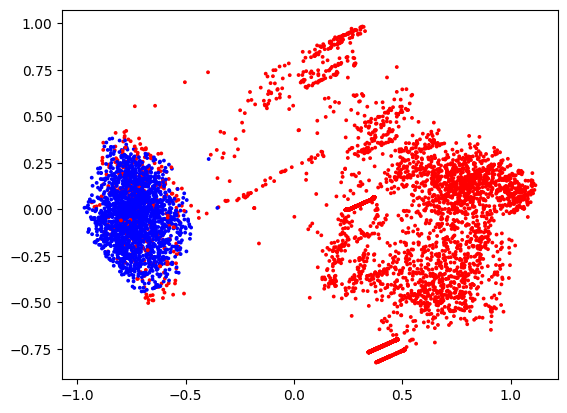

In [281]:
# # Convert dataframe to numoy array
dataset_test = dataset_test.to_numpy()

colors = []

for score in scores:
    if score > valor_umbral:
        colors.append('red')
    else:
        colors.append('blue')

# for anomalo in anomalias:
#     if anomalo:
#         colors.append('red')
#     else:
#         colors.append('blue')

plt.scatter(dataset_test[:, 0], dataset_test[:, 1], color=colors, s=3.0, label="Data points")




# plt.axis("tight")
# plt.title("One Class SVM")
# plt.show()


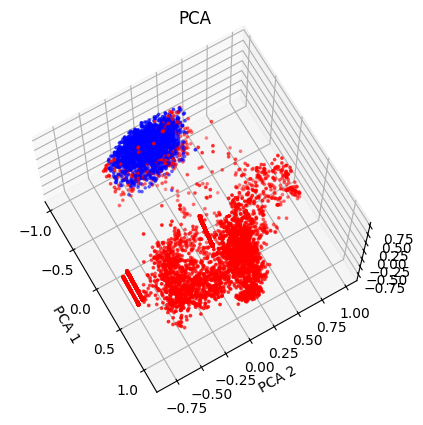

In [282]:
# Print in 3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset_test[:, 0], dataset_test[:, 1], dataset_test[:, 2], color=colors, s=3.0)


# Cambia el punto de vista
ax.view_init(elev=70, azim=-30)

plt.title('PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()
